In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sfma.api import SFMAModel

In [2]:
df = pd.read_csv("../data/gdp-le.csv")

In [3]:
uhc = pd.read_csv("../data/uhc.csv")

In [4]:
df = df.loc[~np.isnan(df.gdp.values)]
df = df.loc[~np.isnan(df[["le"]].values)]

# Adding intercept and null value (for zeroes)
df["int"] = 1.
df["null"] = 1e-3

# Log of life expectancy and GDP for modeling
df["log.le"] = np.log(df["le"])
df["log.gdp"] = np.log(df["gdp"])

df.sort_values('gdp', inplace=True)

In [5]:
plt.style.use('seaborn-dark-palette')

In [5]:
italy = df["country"].isin(["Italy"]).values
greece = df["country"].isin(["Greece"]).values
spain = df["country"].isin(["Spain"]).values
portugal = df["country"].isin(["Portugal"]).values

In [6]:
other = ~italy & ~greece & ~spain & ~portugal

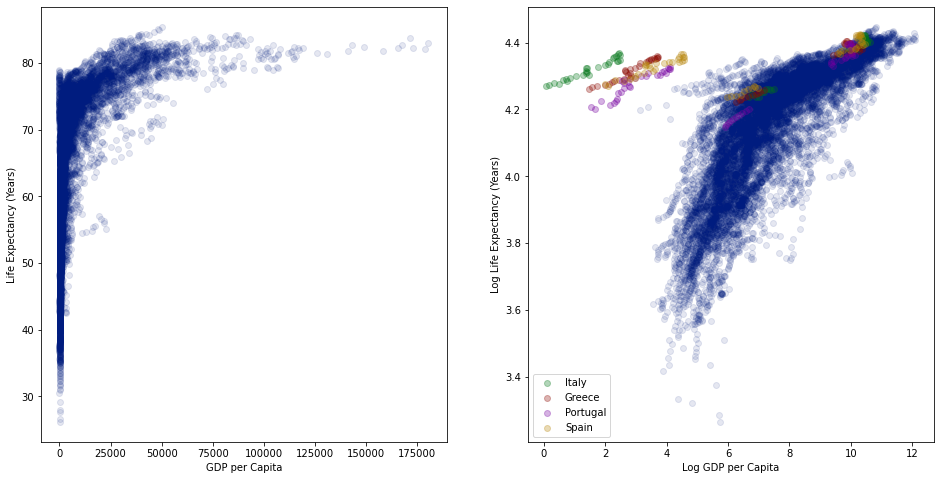

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(df[["gdp"]], df[["le"]], alpha=0.1)
ax[1].scatter(df[["log.gdp"]][other], df[["log.le"]][other], alpha=0.1)
ax[0].set_xlabel("GDP per Capita")
ax[0].set_ylabel("Life Expectancy (Years)")
ax[1].set_xlabel("Log GDP per Capita")
ax[1].set_ylabel("Log Life Expectancy (Years)")

ax[1].scatter(df[["log.gdp"]][italy], df[["log.le"]][italy], alpha=0.3, label="Italy")
ax[1].scatter(df[["log.gdp"]][greece], df[["log.le"]][greece], alpha=0.3, label="Greece")
ax[1].scatter(df[["log.gdp"]][portugal], df[["log.le"]][portugal], alpha=0.3, label="Portugal")
ax[1].scatter(df[["log.gdp"]][spain], df[["log.le"]][spain], alpha=0.3, label="Spain")

ax[1].legend()
plt.savefig("GDP-LE-example.pdf")

In [8]:
uhc['uhc_std'] = uhc['uhc_variance']**0.5

In [51]:
model = SFMAModel(
    df=uhc,
    col_output='uhc',
    col_se='uhc_std',
    col_input='physicians',
    concave=True,
    knots_type='domain',
    knots_num=4,
    include_gamma=False,
    increasing=True,
    r_linear=False,
    pct_trimming=0.10,
    constr_grid_num=100
)
model.fit(step_size=100, max_iter=10)

/opt/miniconda3/envs/sfma/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Trimming iteration:  9 / 10 -- error:  0.00216
Model failed to converge! :(


In [22]:
uhc.sort_values("physicians", inplace=True)

In [38]:
uhc['weights'] = model.marginal_model.w

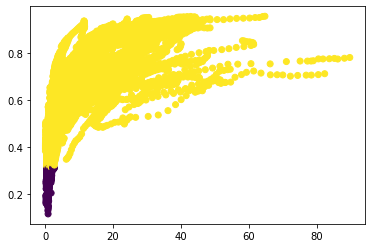

In [40]:
fig, ax = plt.subplots(1)
plt.scatter(uhc['physicians'], uhc['uhc'], c=uhc['weights'])

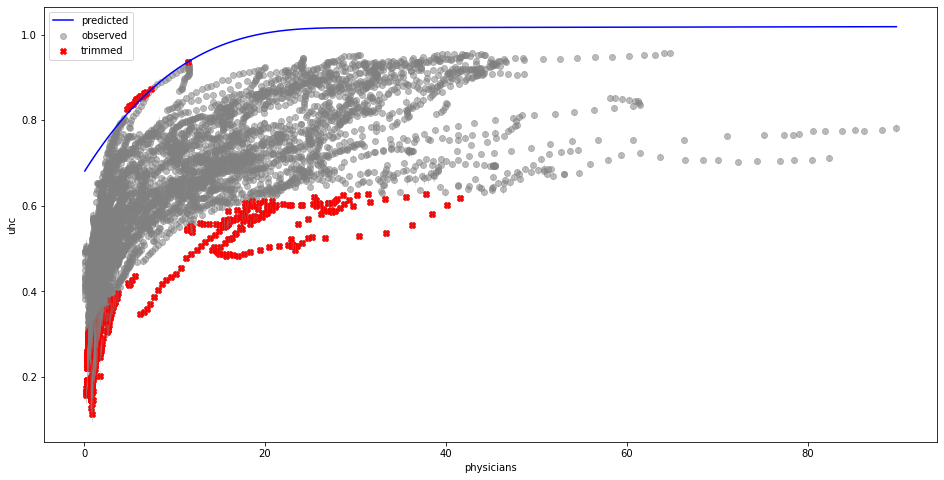

In [52]:
model.plot_frontier(uhc)

In [47]:
model2 = SFMAModel(
    df=uhc.loc[uhc.weights > 0.0],
    col_output='uhc',
    col_se='uhc_std',
    col_input='physicians',
    concave=True,
    knots_type='domain',
    knots_num=4,
    include_gamma=True,
    increasing=True,
    r_linear=True,
    pct_trimming=0.00,
    constr_grid_num=100
)
model2.fit(step_size=100)


Model converged successfully! :)


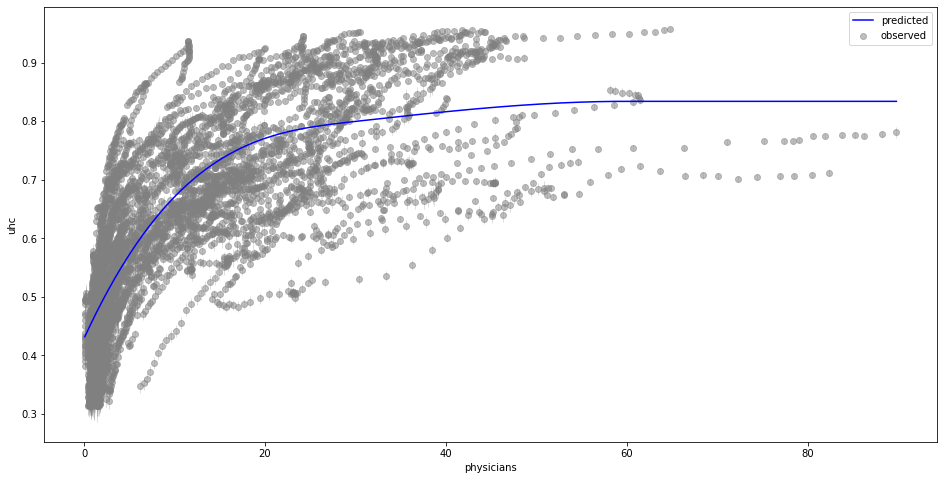

In [48]:
model2.plot_frontier(uhc.loc[uhc.weights > 0.0])